# KdV equation

In [1]:
import jax
import jax.numpy as jnp
from Data import *
from Plot import *
from NeuralNetwork import *
from InitialFit import *
from Solver import *
from Error import *
from JaxUtils import *

### Setup

In [2]:
# Exact solution

def exactKdVTwoSol(x, t):
    '''
    Function taken from https://github.com/pehersto/ng/solvers/exactKdV.py
    Args:
        x: jnp.array, points in space
        t: jnp.array (or float), points in time
    '''

    k = jnp.asarray([1., jnp.sqrt(5.)])
    eta = jnp.asarray([0., 10.73])
    t = jnp.asarray(t) # in case t is a float

    etaMat1 = k[0] * x.reshape((-1, 1)) - k[0] ** 3 * t.reshape((1, -1)) + eta[0]
    etaMat2 = k[1] * x.reshape((-1, 1)) - k[1] ** 3 * t.reshape((1, -1)) + eta[1]
    c = ((k[0] - k[1]) / (k[0] + k[1]) )** 2

    f = 1. + jnp.exp(etaMat1) + jnp.exp(etaMat2) + jnp.multiply(jnp.exp(etaMat1), jnp.exp(etaMat2) * c)
    df = k[0] * jnp.exp(etaMat1) + k[1] * jnp.exp(etaMat2) + c * (k[0] + k[1]) * jnp.multiply(jnp.exp(etaMat1), jnp.exp(etaMat2))
    ddf = k[0] ** 2 * jnp.exp(etaMat1) + k[1] ** 2 * jnp.exp(etaMat2) + c * (k[0] + k[1]) ** 2 * jnp.multiply(jnp.exp(etaMat1), jnp.exp(etaMat2))

    y = 2 * jnp.divide(jnp.multiply(f, ddf) - df ** 2, f ** 2)

    y = jnp.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0) # avoid numerical errors far outside of [-1, 2]
    
    return y

In [3]:
problem_data = ProblemData(name='kdv', # problem name
                           d=1, # input dimension
                           domain=(-20, 40), # 1D: (lower, upper)
                           T=4, # final time
                           initial_fn=lambda x: exactKdVTwoSol(x, 0), # initial condition
                           N=2048, # number of spatial points
                           dt=0.01, # time step
                          )

training_data = TrainingData(m=10, # number of neurons per layer
                             batch_size=2000, # batch size
                             epochs=20000, # number of epochs
                             gamma=0.1 # learning rate
                            )

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


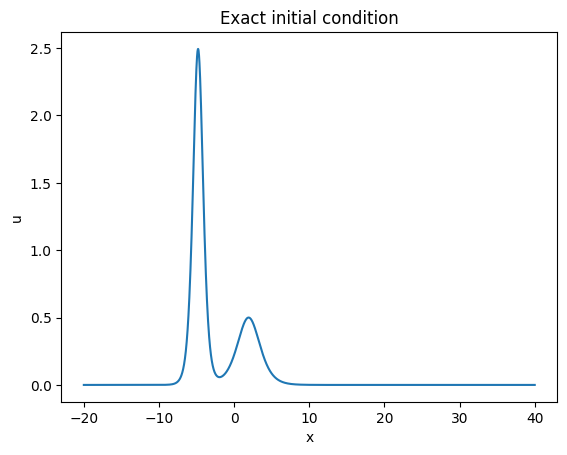

In [4]:
plot_function(problem_data.initial_fn, problem_data, 'Exact initial condition')

In [5]:
print(problem_data)

Problem data:
  name: kdv, d: 1, domain: (-20, 40), T: 4, N: 2048, dt: 0.01


In [6]:
print(training_data)

Training data:
  m: 10, batch size: 2000, epochs: 20000, gamma: 0.1


### Initial fit

In [7]:
# Neural network

net = ShallowNetKdV(training_data.m, problem_data.domain[1] - problem_data.domain[0])
print(net)

ShallowNetKdV(
    # attributes
    m = 10
    L = 60
)


Fitting the initial condition...
epoch 0, loss = 0.8674977421760559, error = 1.1800545454025269
epoch 1000, loss = 6.226394907571375e-05, error = 0.029243104159832
epoch 2000, loss = 4.445873491931707e-05, error = 0.024731824174523354
epoch 3000, loss = 4.3178464693482965e-05, error = 0.02437295764684677
epoch 4000, loss = 4.1286388295702636e-05, error = 0.023832734674215317
epoch 5000, loss = 3.8430222048191354e-05, error = 0.02299320138990879
epoch 6000, loss = 3.42525054293219e-05, error = 0.02170681022107601
epoch 7000, loss = 2.8669743187492713e-05, error = 0.019858678802847862
epoch 8000, loss = 2.2262225684244186e-05, error = 0.017498629167675972
epoch 9000, loss = 1.6470956325065345e-05, error = 0.015051060356199741
epoch 10000, loss = 1.1649865882645827e-05, error = 0.01265824306756258
epoch 11000, loss = 1.0498761184862815e-05, error = 0.01347507443279028
epoch 12000, loss = 7.006230134720681e-06, error = 0.009817195124924183
epoch 13000, loss = 6.094367563491687e-06, error =

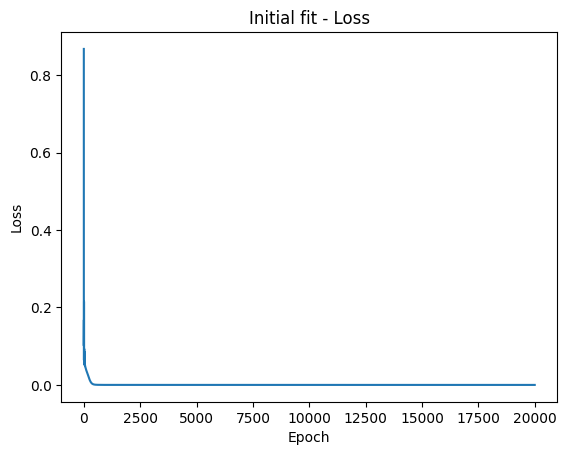

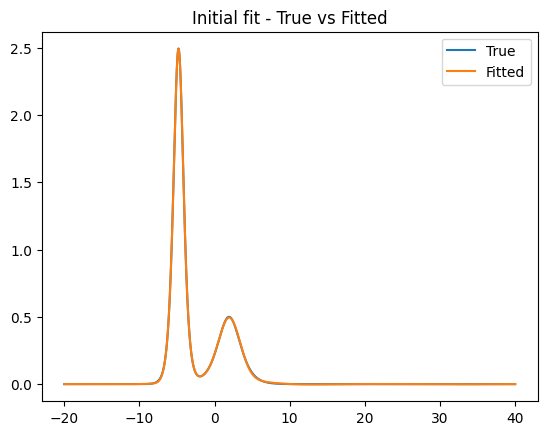

Relative error of the initial fit: 0.0057052765


In [8]:
# Initial fit

initial_fit = True

if initial_fit:
    theta = init_neural_galerkin(net, problem_data, training_data) # train a NN to fit the initial condition
    jnp.save('./data/theta_init_' + problem_data.name +'.npy', theta)
else:
    theta = jnp.load('./data/theta_init_' + problem_data.name + '.npy', allow_pickle=True).item()

### Time evolution

In [9]:
theta_flat, unravel = jax.flatten_util.ravel_pytree(theta) # flatten a pytree of arrays down to a 1D array
u_fn = unraveler(net.apply, unravel) # auxiliary function that allows to evaluate the NN starting from the flattened parameters

# Define gradients
U = jax.vmap(u_fn, (None, 0)) # jax.vmap(fun, in_axes)
U_dtheta = jax.vmap(jax.grad(u_fn), (None, 0))
U_dx = jax.vmap(gradsqz(u_fn, 1), (None, 0))
U_dddx = jax.vmap(gradsqz(gradsqz(gradsqz(u_fn, 1), 1), 1), (None, 0))

# Source term for the KdV equation
def rhs(theta_flat, x, t):
    u = U(theta_flat, x)
    u_x = U_dx(theta_flat, x)
    u_xxx = U_dddx(theta_flat, x)
    return - u_xxx - 6 * u * u_x

In [10]:
# TODO: is there a way to put these functions in a separate file?

@jax.jit
def M_fn(theta_flat, x):
    '''
    Assemble the M matrix.
    '''
    u_dth = U_dtheta(theta_flat, x)
    M = jnp.mean(u_dth[:, :, jnp.newaxis] * u_dth[:, jnp.newaxis, :], axis=0)
    return M


@jax.jit
def F_fn(theta_flat, x, t):
    '''
    Assemble the F matrix.
    '''
    u_dth = U_dtheta(theta_flat, x)
    f = rhs(theta_flat, x, t) # source term
    F = jnp.mean(u_dth[:, :] * f[:, jnp.newaxis], axis=0)
    return F


@jax.jit
def r_fn(theta_flat, theta_flat_k, x, t):
    '''
    Compute the local-in-time residual.
    '''
    return jnp.dot(M_fn(theta_flat, x), theta_flat) - jnp.dot(M_fn(theta_flat, x), theta_flat_k) - \
        problem_data.dt * F_fn(theta_flat, x, t + problem_data.dt)


@jax.jit
def r_loss(theta_flat, theta_flat_k, x, t):
    '''
    Compute the norm of the residual.
    '''
    return jnp.linalg.norm(r_fn(theta_flat, theta_flat_k, x, t))

In [11]:
def neural_galerkin(theta_flat, problem_data, n, sampler, scheme):

    x_plot = jnp.linspace(problem_data.domain[0], problem_data.domain[1], problem_data.N) # points for plotting and error evaluation

    solution = []

    print('Run time evolution...')

    t = 0
    while t < problem_data.T:

        if int(t / problem_data.dt) % 50 == 0:
            print(f'  t = {t:.2f}/{problem_data.T:.2f}')

        # Save current solution
        u = U(theta_flat, x_plot.reshape(-1, 1))
        solution.append(u)

        # Sample points in the spatial domain
        if sampler == 'unif':
            seed = int(t * 1e6)
            x = jax.random.uniform(jax.random.key(seed), (n, problem_data.d), minval=problem_data.domain[0], maxval=problem_data.domain[1])
        else:
            print('Sampling strategy not implement yet.')
            raise NotImplementedError

        if scheme == 'rk45':
            theta_flat = runge_kutta_scheme(theta_flat, x, t, problem_data.dt, M_fn, F_fn)
        elif scheme == 'bweuler':
            theta_flat = backward_euler_scheme(theta_flat, x, t, r_loss)
        else:
            print('ODE solver not implemented yet.')
            raise NotImplementedError

        t = t + problem_data.dt

    return solution

In [12]:
solution = neural_galerkin(theta_flat=theta_flat, # parameters
                           problem_data=problem_data, # problem data
                           n=1000, # sample points
                           sampler='unif', # sampling strategy
                           scheme='rk45' # ODE solver
                          )

Run time evolution...
  t = 0.00/4.00
  t = 0.50/4.00
  t = 1.00/4.00
  t = 1.50/4.00
  t = 2.00/4.00
  t = 2.51/4.00
  t = 3.01/4.00
  t = 3.51/4.00


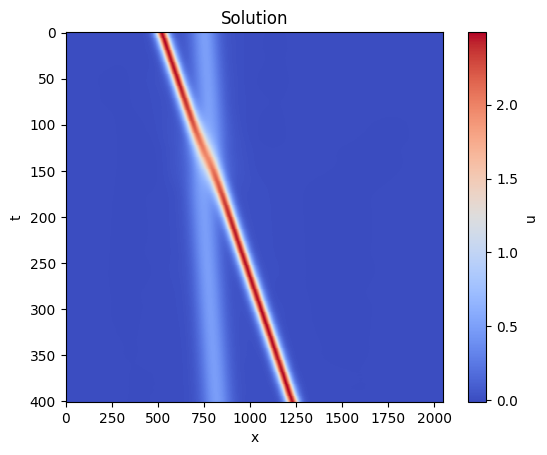

In [13]:
plot_solution(solution)

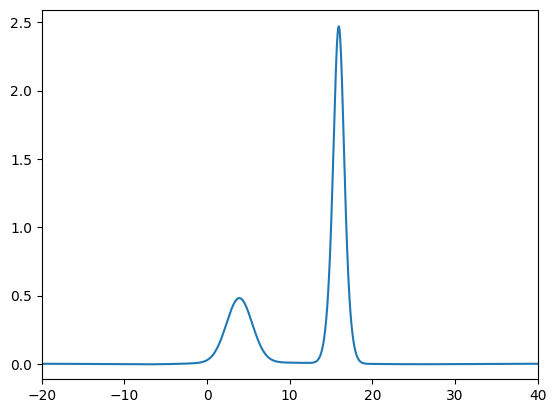

In [14]:
plot_animation(solution, problem_data)

### Compute relative error

In [15]:
errors = compute_error(solution, exactKdVTwoSol, problem_data)

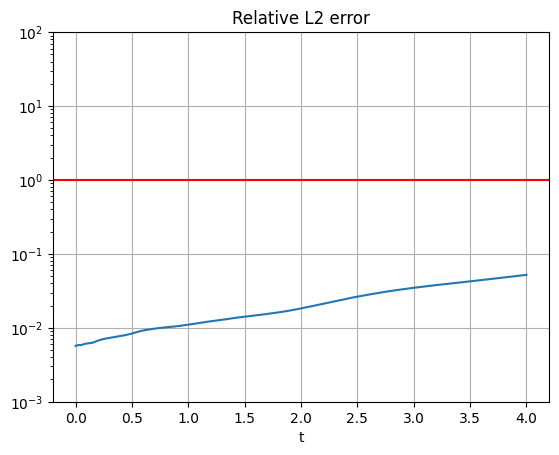

In [16]:
plot_error(errors, problem_data, 'Relative L2 error')